### In this notebook, we begin to explore the DHS x Component (Mixture) NMF decomposed matrix. Specifically, we look at what it means for a DHS component vector to be represented by more than on non-zero NMF component.

First, load in libraries and data as usual

In [1]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('/Users/amuratov/gits/EncodeNMF')

import OONMF
import OONMFhelpers as OH
import OONMFmetadata as OMD


In [2]:
myNMF = OONMF.NMFobject(16)


In [6]:
myNMF.matrix_input_name('data/2018-06-08NC16_NNDSVD_Basis.npy', 'data/2018-06-08NC16_NNDSVD_Mixture.npy')


In [7]:
myNMF.read_matrix_input()


In [8]:
myNMF.normalize_matrices()

In [9]:
myNMF.NormedBasis.shape

(733, 16)

### here, we use the normalized version of the decomposed matrices. This means that for a given biosample or DHS, the sum of all components is equal to 1 

In [10]:
myNMF.NormedMixture.shape

(16, 3591898)

In [11]:
np.sum(myNMF.NormedMixture[:,0])

1.0

In [12]:
np.sum(myNMF.NormedBasis[0])

1.0

In [13]:
myNMF.define_colors()

In [73]:
# check sparsity of matrix
print('sparsity of mixture ',np.sum(myNMF.NormedMixture==0) / (myNMF.NormedMixture.shape[0] * myNMF.NormedMixture.shape[1]))
print('sparsity of basis ', np.sum(myNMF.NormedBasis==0) / (myNMF.NormedBasis.shape[0] * myNMF.NormedBasis.shape[1]))

sparsity of mixture  0.7064853317104216
sparsity of basis  0.6572305593451568


#### although we could use different thresholds, the sparsity of the Mixture matrix (70.6%) means that we should see interesting results just by considering non-zero component loadings

In [14]:
non_zero_mixture = myNMF.NormedMixture > 0


In [15]:
non_zero_mixture.shape

(16, 3591898)

In [74]:
#number of DHSs with N non-zero components
Num_nonzero_DHS_per_Ncomps = pd.Series(np.sum(non_zero_mixture, axis=0)).value_counts().sort_index()

In [24]:
Num_nonzero_DHS_per_Ncomps

1     372894
2     653744
3     539539
4     397185
5     423948
6     349787
7     263433
8     176308
9     142277
10    103264
11     54389
12     31797
13     21877
14     17996
15     16981
16     26479
dtype: int64

#### what fraction of DHSs have only a single non-zero component?

In [26]:
Num_nonzero_DHS_per_Ncomps[1] / Num_nonzero_DHS_per_Ncomps.sum()

0.10381530878660808

#### just 10.4%

<Figure size 432x288 with 0 Axes>

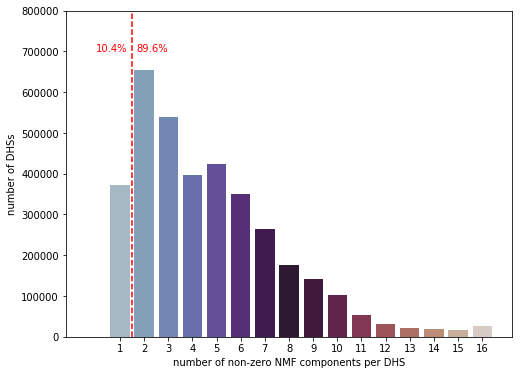

In [75]:
plt.clf()
plt.figure(figsize=(8,6))
sns.barplot(x=np.arange(17), y=np.bincount(np.sum(non_zero_mixture, axis=0), minlength=17), palette = sns.color_palette("twilight", 17))
plt.xticks(np.arange(1,17), (np.arange(1,17)).astype(str))
plt.plot([1.5, 1.5], [0,800_000], '--r')
plt.ylim([0,800_000])
plt.text(1.7, 700_000, '89.6%', color='red')
plt.text(0.0, 700_000, '10.4%', color='red')

plt.xlabel('number of non-zero NMF components per DHS')
plt.ylabel('number of DHSs')
plt.show()

## For the next part, we will be needing the masterlist to see numnber of samples per DHS. I will calculate the relationship between the number of non-zero NMF components per DHS, and the number of samples that DHS actually occurs in.

In [28]:
ML = pd.read_table('masterlist_DHSs_733samples_WM20180608_all_indexIDs.txt', names=['chrom','start','end','id','ML4','ML5','ML6','ML7','ML8','ML9','ML10'], header=None)


In [30]:
ML.head()

,chrom,start,end,id,ML4,ML5,ML6,ML7,ML8,ML9,ML10
0,chr1,16140,16200,1.10011,0.129388,1,1,60,16170,16170.0,16170.0
1,chr1,51868,52040,1.10021,0.080034,1,1,172,51970,51970.0,51970.0
2,chr1,57280,57354,1.10025,1.093002,4,4,74,57350,57350.0,57350.0
3,chr1,66370,66482,1.10027,1.469725,8,8,112,66430,66410.0,66430.0
4,chr1,79100,79231,1.1003,0.226098,2,2,131,79150,79150.0,79150.0


In [31]:
ML.shape

(3591898, 11)

In [32]:
ML['N_nonzero'] = np.sum(non_zero_mixture, axis=0)

In [33]:
ML.head()

,chrom,start,end,id,ML4,ML5,ML6,ML7,ML8,ML9,ML10,N_nonzero
0,chr1,16140,16200,1.10011,0.129388,1,1,60,16170,16170.0,16170.0,3
1,chr1,51868,52040,1.10021,0.080034,1,1,172,51970,51970.0,51970.0,2
2,chr1,57280,57354,1.10025,1.093002,4,4,74,57350,57350.0,57350.0,1
3,chr1,66370,66482,1.10027,1.469725,8,8,112,66430,66410.0,66430.0,8
4,chr1,79100,79231,1.1003,0.226098,2,2,131,79150,79150.0,79150.0,6


<Figure size 432x288 with 0 Axes>

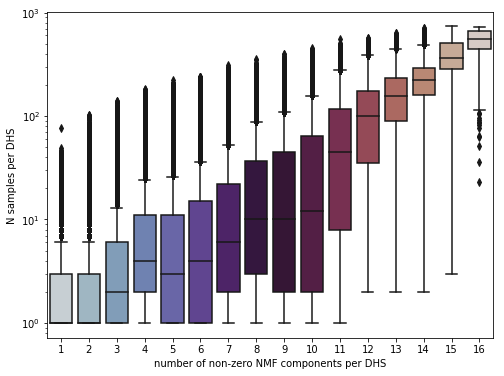

In [76]:
plt.clf()
plt.figure(figsize=(8,6))
sns.boxplot(y='ML5', x='N_nonzero', data=ML, palette = sns.color_palette("twilight", 16))
plt.yscale('log')
plt.ylabel('N samples per DHS')
plt.xlabel('number of non-zero NMF components per DHS')
plt.show()


### pretty good correlation! 

### now lets bring in the metadata and study number of systems per DHS. I will also need the full presence-absence matrix since this is not a quantity that was previously calculated in the masterlist

In [37]:
def acquire_data():
    # fill in for whatever application
    A = pd.read_table('matrix_bin_all_733samples_WM20180608.txt', header=None)
    return A.drop([A.columns[0]], axis=1).values.T

In [38]:
ML_matrix  = acquire_data()

In [77]:
ML_matrix.shape

(733, 3591898)

In [40]:
finname = 'ENCODE 733-sample list WM20180608 - ENCODE3 metadata 2-04-19.tsv'
MetaData  = pd.read_csv(finname, sep='\t')


In [42]:
sampnamePD = pd.read_table('sampnams_733.txt', header=None, names=['LN', 'DS', 'type'])
sampnamePD['full_name'] = sampnamePD.LN + '-' + sampnamePD.DS + '-' + sampnamePD.type

In [43]:
systems_to_check = MetaData.system.value_counts().keys().values

In [45]:
num_systems_arr = []
for system in systems_to_check:
    syscut = MetaData.system.values == system
    number_of_system_in_DHS = np.sum(ML_matrix[syscut], axis=0)
    num_systems_arr.append(number_of_system_in_DHS)

In [46]:
num_systems_arr = np.array(num_systems_arr)

In [47]:
systems_per_DHS_table = pd.DataFrame(num_systems_arr.T, columns=systems_to_check)

### in addition to the number of systems, we can look at the number of system-subsystem combos

In [48]:
MetaData.subsystem.fillna('Only', inplace=True)

In [49]:
MetaData['system-subsystem'] = MetaData.system + '-' +MetaData.subsystem

In [79]:
# here are the system-subsystem combos
MetaData['system-subsystem'].value_counts()

Renal-Only                         100
Connective-Only                     91
Nervous-Only                        72
Digestive-Only                      60
Musculoskeletal-Skeletal Muscle     50
Respiratory-Only                    48
Hematopoietic-T-cell                33
Embryonic-Only                      26
Cardiovascular-Cardiac              24
Integumentary-Only                  24
Musculoskeletal-Only                24
Epithelial-Only                     23
Hematopoietic-Lymphoid              22
Fetal Life Support-Only             21
Cardiovascular-Vascular             20
Hematopoietic-Progenitor            19
Hematopoietic-Erythroid             16
Genitourinary-Only                  14
Hematopoietic-Myeloid               13
Cardiovascular-Cardiac Muscle       10
Endocrine-Only                       9
Hepatic-Only                         6
Hematopoietic-Only                   6
Musculoskeletal-Smooth Muscle        2
Name: system-subsystem, dtype: int64

In [50]:
system_combos_to_check = MetaData['system-subsystem'].value_counts().keys().values

In [52]:
num_system_combos_arr = []
for system_combo in system_combos_to_check:
    syscut = MetaData['system-subsystem'].values == system_combo
    number_of_system_in_DHS = np.sum(ML_matrix[syscut], axis=0)
    num_system_combos_arr.append(number_of_system_in_DHS)

In [53]:
num_system_combos_arr = np.array(num_system_combos_arr)

In [54]:
system_combos_per_DHS_table = pd.DataFrame(num_system_combos_arr.T, columns=system_combos_to_check)

In [56]:
system_combos_per_DHS_table.shape

(3591898, 24)

In [57]:
num_system_combos_arr>0

(24, 3591898)

#### All we really care about is that the DHS contains in at least one sample from a given system or system-subsystem combo

In [58]:
ML['n_systems_per_DHS'] = np.sum(systems_per_DHS_table.values > 0 , axis=1)
ML['n_combos_per_DHS'] =  np.sum(system_combos_per_DHS_table.values > 0 , axis=1)

<Figure size 432x288 with 0 Axes>

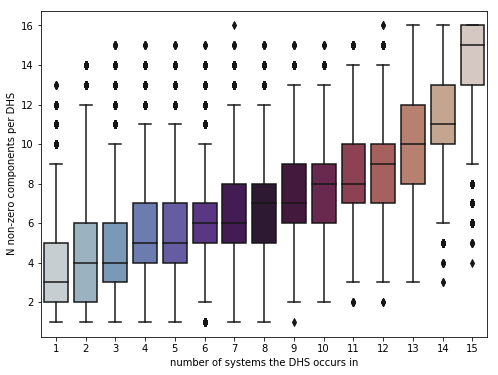

In [59]:
plt.clf()
plt.figure(figsize=(8,6))
sns.boxplot(y='N_nonzero', x='n_systems_per_DHS', data=ML, palette = sns.color_palette("twilight", 15))
#plt.yscale('log')
plt.ylabel('N non-zero components per DHS')
plt.xlabel('number of systems the DHS occurs in')
plt.show()


<Figure size 432x288 with 0 Axes>

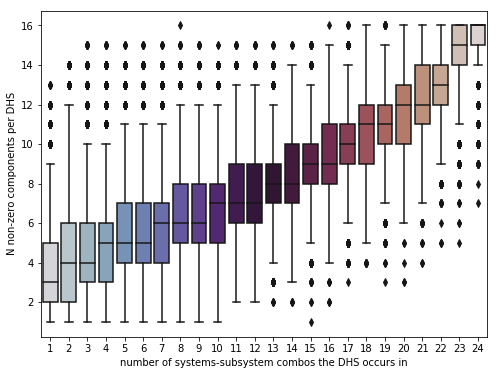

In [60]:
plt.clf()
plt.figure(figsize=(8,6))
sns.boxplot(y='N_nonzero', x='n_combos_per_DHS', data=ML, palette = sns.color_palette("twilight", 24))
#plt.yscale('log')
plt.ylabel('N non-zero components per DHS')
plt.xlabel('number of systems-subsystem combos the DHS occurs in')
plt.show()

#### both trends look pretty good with robust correlations for both medians and quartiles


#### Just to make sure there are signififcant numbers in each bin, the plot below  shows the number of systems each DHS occurs in 

<Figure size 432x288 with 0 Axes>

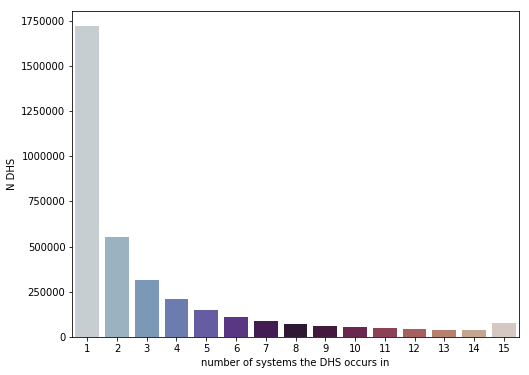

In [61]:
plt.clf()
plt.figure(figsize=(8,6))
sns.countplot(x='n_systems_per_DHS', data=ML, palette = sns.color_palette("twilight", 15))
#plt.yscale('log')
plt.ylabel('N DHS')
plt.xlabel('number of systems the DHS occurs in')
plt.show()

#### definitely a lot more in n_systems=1 than anything else, but still pretty good numbers even up to 15 systems

#### what about system-subsystem combos? Below, we see that these numbers are a little more iffy in the high number bins. So systems alone are probably more robust to use, though impressive we still see solid correlation structure in quartile plots

<Figure size 432x288 with 0 Axes>

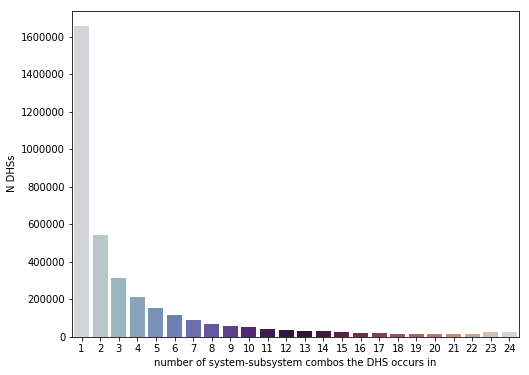

In [80]:
plt.clf()
plt.figure(figsize=(8,6))
sns.countplot(x='n_combos_per_DHS', data=ML, palette = sns.color_palette("twilight", 24))
#plt.yscale('log')
plt.ylabel('N DHSs')
plt.xlabel('number of system-subsystem combos the DHS occurs in')
plt.show()

### finally lets make some stacked bar-plot representations of DHSs that occur in $N$ systems for $N=1-15$. DHSs are randomly sampled for each value of $N$

In [64]:
WSO = np.array([7,5,15,9,12,14,3,8,13,2,4,6,16,11,10,1]).astype(int) - 1


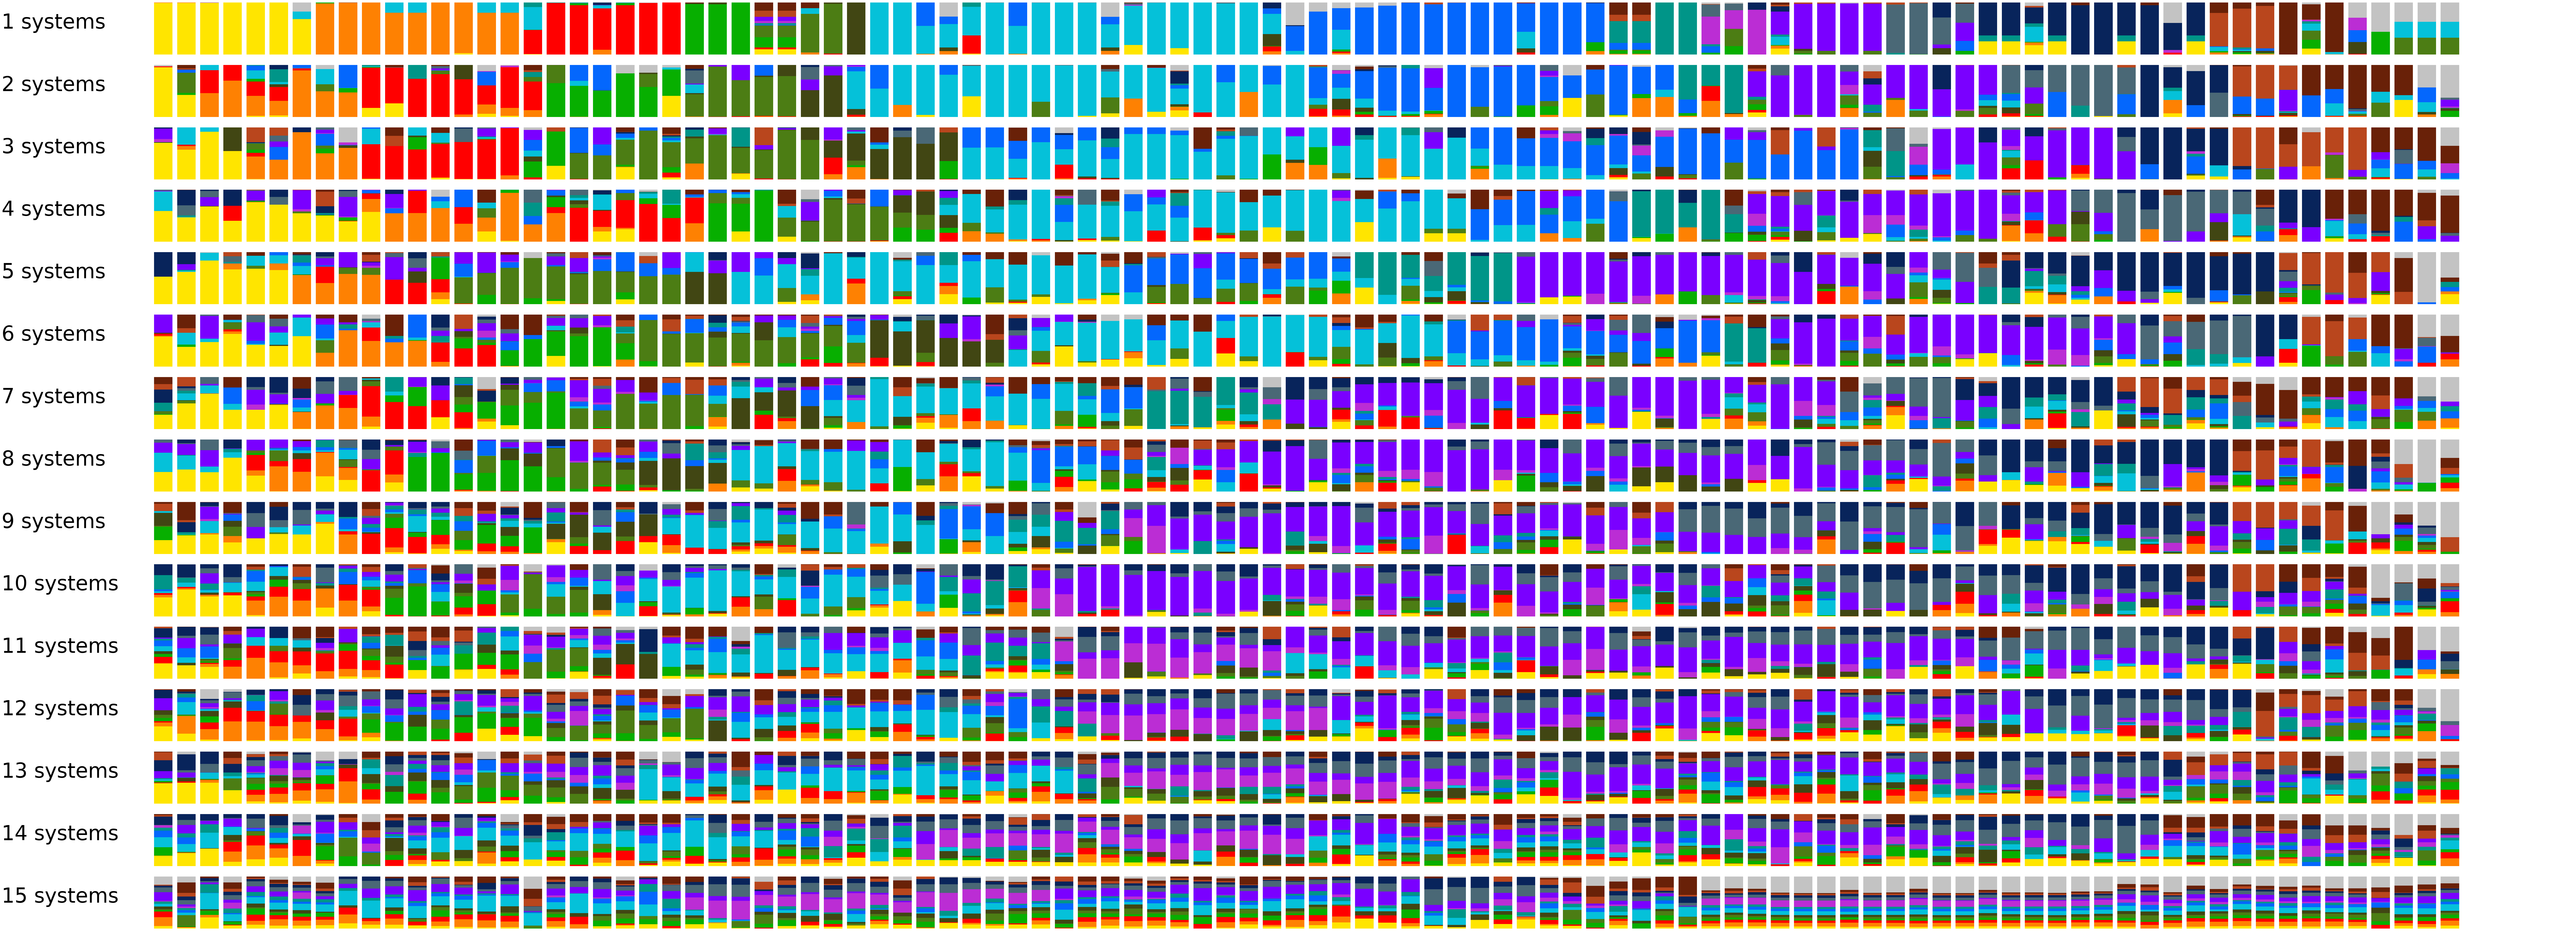

In [68]:
fig, axes = plt.subplots(15, 1, sharex=True, figsize=(200, 15*5))
for i in range(1, 16):
    cut = ML['n_systems_per_DHS'] == i
    funchoice = np.random.choice(ML[cut].index.values, size=100, replace=False)
    minimix = myNMF.NormedMixture.T[funchoice]
    minimixT = minimix.T
    thebarsortorder = OH.get_barsortorder_OfficialOrder(minimix)

    ttt = np.arange(minimix.shape[0])
    ground_pSample = ttt*0
    for k in range(16):
        axes[i-1].bar(ttt,minimixT[WSO][k][thebarsortorder], bottom = ground_pSample, color=np.array(myNMF.Comp_colors)[WSO][k], alpha=1.0)
        ground_pSample = np.sum(minimixT[WSO][0: k+1], axis=0)[thebarsortorder]
    axes[i-1].axis('off')
    axes[i-1].text(-7, 0.5, str(i)+' systems', fontsize=90)


fig.savefig('42519_masterpiece_systems.pdf', bbox_inches='tight')
plt.show()
